# What is the relationship between chronic school absenteeism and class size? 

## A Chronic School Absenteeism Regression Analysis of Public Schools in NYC 2016-2023

# Executive Summary

This analysis investigates the relationship between chronic school absenteeism in New York City public schools and class size and pupil-teacher ratio. Chronic absenteeism, a critical indicator of school quality and student success, remains a significant challenge, with 41% of NYC public school students chronically absent in the 2022-2023 school year.

One of the most important recent policy measures that the NYC Department of Education (DOE) undertook to respond to this and other education quality concerns, is to decrease class sizes by a local law that requires schools in New York City to reduce their class sizes over the course of five years. The law was signed by the New York State governor in 2022.

The analysis reveals an unexpected negative relationship between chronic absenteeism and both class size and pupil-teacher ratio. In other words, contrary to expectations, chronic absenteeism tends to increase as class sizes and pupil-teacher ratio decrease. The effect of class size on absenteeism is relatively small, with a 0.29 decrease in absenteeism for each one-unit increase in class size. However, the relationship with pupil-teacher ratio is stronger: the model predicts nearly 2 fewer chronically absent students for each unit increase in pupil-teacher ratio (i.e., more students per teacher).

While these results are statistically significant, they explain only 17.8% of the variation in absenteeism. This suggests that other important factors—such as teacher quality, student engagement, classroom resources and factors external to the school (health and family situation) are likely influencing absenteeism rates, and these factors are not captured in the current model.

Although the study indicates that reducing class sizes may not be the most effective policy to reduce absenteeism, the findings underscore the complexity of addressing chronic absenteeism. Further research is needed to explore the role of additional variables and to evaluate the broader impact of educational policies like class size reduction.

For more insights, this [visual exploratory analysis on chronic absenteeism in NYC public schools](https://public.tableau.com/app/profile/lyuba3471/viz/ChronicSchoolAbsenteeisminNYCPublicSchools/ChronicSchoolAbsenteeisminNYCPublicSchools) provides additional context and detail.


# Introduction
Chronic school absenteeism - defined as missing at least 10% of schoool days in a school year - is the main indicator of school quality and student success that states in the U.S. have used to meet the requirements of the 2015 Every Student Succeeds Act governing the country’s K–12 public education policy.

Chronic school absenteeism puts students at high risk of falling behind at school and dropping out.

In 2016 the first US Education Department report since the Act showed that more than 6 million students in the US were chronically absent, meaning they missed more than 15 school days in a year. Six years and the Covid-19 pandemic later, the latest figures remain disquieting. Looking at New York City (NYC) only, the chronic school absenteeism rate in public schools in the school year 2022-2023 was 41%.

One of the most important recent policy measures that the NYC Department of Education (DOE) undertook to respond to this and other education quality concerns, is to decrease class sizes by a local law that requires schools in New York City to reduce their class sizes to no more than 20 students in grades K–3, 23 students in grades 4–8, and 25 students in high school over the next five years. The law was signed by the New York State governor in 2022.

This has been a controversial measure as studies have shown limited impact on education quality and outcomes for students, while the cost is high. 

This project aims to use NYC Open Data to understand the chronic school absenteeism trends in NYC and to see if there is any historical correlation between smaller class sizes and smaller pupil-teacher ratios and lower school absenteeism rates as an indicator of education quality.

## 1. Load the data

The original NYC Open Data / Department of Education (DOE) files are in xlsx format containing multiple sheets. We need to transform them to CSV files containing separate sheets, and to merge the CSV files containing the same data for different school years.

In the analysis we will use data for all students and all grades.

In [1]:
# import libraries

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
# define the list of class size Excel files to save as CSV files
excel_files_classsize = ['2016_2017_avg_classsize_school.xlsx', '2017_2018_avg_classsize_school.xlsx', '2018_2019-avg-class-size-school.xlsx', '2019_2020_avg_classsize_school.xlsx', '2020_2021_avg_classsize_school.xlsx', '2021_2022_avg_classsize_school.xlsx', '2022_2023_avg_classsize_school.xlsx']

# iterate over each Excel file and save each sheet as a separate CSV file
for file in excel_files_classsize:
    excel_data = pd.ExcelFile(file)
    for sheet_name in excel_data.sheet_names:
        csv_file_name = f'{os.path.splitext(file)[0]}_{sheet_name}.csv'
        if not os.path.exists(csv_file_name):
            df = excel_data.parse(sheet_name)
            df.to_csv(csv_file_name, index=False)
        else:
            print(f"CSV file '{csv_file_name}' already exists.")

CSV file '2016_2017_avg_classsize_school_K-8 Avg.csv' already exists.
CSV file '2016_2017_avg_classsize_school_MS HS Avg.csv' already exists.
CSV file '2016_2017_avg_classsize_school_PTR.csv' already exists.
CSV file '2017_2018_avg_classsize_school_K-8 Avg.csv' already exists.
CSV file '2017_2018_avg_classsize_school_MS HS Avg.csv' already exists.
CSV file '2017_2018_avg_classsize_school_PTR.csv' already exists.
CSV file '2018_2019-avg-class-size-school_K-8 Avg.csv' already exists.
CSV file '2018_2019-avg-class-size-school_MS HS Avg.csv' already exists.
CSV file '2018_2019-avg-class-size-school_PTR.csv' already exists.
CSV file '2019_2020_avg_classsize_school_K-8 Avg.csv' already exists.
CSV file '2019_2020_avg_classsize_school_MS HS Avg.csv' already exists.
CSV file '2019_2020_avg_classsize_school_PTR.csv' already exists.
CSV file '2020_2021_avg_classsize_school_K-8.csv' already exists.
CSV file '2020_2021_avg_classsize_school_MS & HS.csv' already exists.
CSV file '2020_2021_avg_class

In [3]:
# after checking that the files are structured in the same way, merge all class size csv files in a new csv file

# get the directory where the Jupyter Notebook is located
notebook_directory = os.getcwd()

# specify the names of the CSV files to merge
files_to_merge = ['2016_2017_avg_classsize_school_K-8 Avg.csv', '2016_2017_avg_classsize_school_MS HS Avg.csv', '2017_2018_avg_classsize_school_K-8 Avg.csv', '2017_2018_avg_classsize_school_MS HS Avg.csv',  '2018_2019-avg-class-size-school_K-8 Avg.csv', '2018_2019-avg-class-size-school_MS HS Avg.csv', '2019_2020_avg_classsize_school_K-8 Avg.csv', '2019_2020_avg_classsize_school_MS HS Avg.csv','2020_2021_avg_classsize_school_K-8.csv','2020_2021_avg_classsize_school_MS & HS.csv', '2021_2022_avg_classsize_school_K-8 Avg.csv', '2021_2022_avg_classsize_school_MS HS Avg.csv', '2022_2023_avg_classsize_school_K-8 Avg.csv', '2022_2023_avg_classsize_school_MS HS Avg.csv']

# create an empty list to store data frames for the files to merge
dfs_to_merge = []

# read the CSV files to merge
for file_to_merge in files_to_merge:
    # Read CSV file into DataFrame
    df = pd.read_csv(os.path.join(notebook_directory, file_to_merge))
    # Append DataFrame to list
    dfs_to_merge.append(df)

# check if the merged class size CSV file already exists
merged_csv_file = 'merged_classsize_data.csv'
if not os.path.exists(merged_csv_file): 

    # if not, merge DataFrames
    merged_df = pd.concat(dfs_to_merge, ignore_index=True)

    # save merged DataFrame
    merged_csv_file = 'merged_classsize_data.csv'
    merged_df.to_csv(merged_csv_file, index=False)
    
    print ("Merged CSV file saved.")
else:
    print("Merged CSV file already exists.")


Merged CSV file already exists.


In [4]:
# as above, merge all pupil-teacher ratio (PTR) csv files in a new csv file

# get the directory where the Jupyter Notebook is located
notebook_directory = os.getcwd()

# specify the names of the CSV files to merge
files_to_merge = ['2016_2017_avg_classsize_school_PTR.csv', '2017_2018_avg_classsize_school_PTR.csv', '2018_2019-avg-class-size-school_PTR.csv', '2019_2020_avg_classsize_school_PTR.csv', '2020_2021_avg_classsize_school_Ratio.csv', '2021_2022_avg_classsize_school_PTR.csv', '2022_2023_avg_classsize_school_PTR.csv']

# create an empty list to store data frames for the files to merge
dfs_to_merge = []

# read the CSV files to merge
for file_to_merge in files_to_merge:
    # Read CSV file into DataFrame
    df = pd.read_csv(os.path.join(notebook_directory, file_to_merge))
    # Append DataFrame to list
    dfs_to_merge.append(df)

# check if the merged class size CSV file already exists
merged_csv_file = 'merged_PTR_data.csv'
if not os.path.exists(merged_csv_file): 

    # if not, merge DataFrames
    merged_df = pd.concat(dfs_to_merge, ignore_index=True)

    # save merged DataFrame
    merged_csv_file = 'merged_PTR_data.csv'
    merged_df.to_csv(merged_csv_file, index=False)
    
    print ("Merged CSV file saved.")
else:
    print("Merged CSV file already exists.")


Merged CSV file already exists.


## 2. Data Cleaning

To prepare the attendance data for analysis, we need to first clean and transform the data where necessary.

We will check each of the three CSV files for the following:

1. Blanks (missing values)
2. Data types
3. Duplicates
4. Standardized naming conventions
5. Value and category consistency within and between the datasets (school names, grades, etc)
6. Validity (grades, % within expected ranges)
7. Typos and errors

Then, we need to find the following data per school for the total period of analysis:
(1) the average chronic absenteeism rate,
(2) the average class size, and 
(3) the average pupil-student ratio.


In [5]:
# first, let's have a look at some of the dataframes' characteristics

# load the CSV files into a dataframe
df_attendance = pd.read_csv('clean_dataset_school_all.csv')
df_classsize = pd.read_csv('merged_classsize_data.csv')
df_PTR = pd.read_csv('merged_PTR_data.csv')

# explore the dataframe
print('Attendance Data')
df_attendance.info()
print('')

print('Class Size Data')
df_classsize.info()
print('')
       
print('PTR')
df_PTR.info()
print('')

Attendance Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75365 entries, 0 to 75364
Data columns (total 13 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   dbn                                            75365 non-null  object 
 1   school_name                                    75365 non-null  object 
 2   grade                                          75365 non-null  object 
 3   category                                       75365 non-null  object 
 4   year                                           75365 non-null  int64  
 5   #_total_days                                   75365 non-null  int64  
 6   #_days_absent                                  75365 non-null  int64  
 7   #_days_present                                 75365 non-null  int64  
 8   %_attendance                                   75365 non-null  float64
 9   #_contributing_10+_total_days_and_

We will change the column names to standardize them and make them easier to work with.

There are missing values only in the class size data in the department and subject columns. We can drop these as we won't use them in the analysis anyway.

There are columns in the attendance and the class size data that we will use in the analysis are strings instead of numeric data types.


In [6]:
# clean column names
df_attendance.columns = df_attendance.columns.str.lower().str.replace(' ', '_')
df_classsize.columns = df_classsize.columns.str.lower().str.replace(' ', '_')
df_PTR.columns = df_PTR.columns.str.lower().str.replace(' ', '_')

# check result
print('Attendance Data')
df_attendance.info()
print('')

print('Class Size Data')
df_classsize.info()
print('')
       
print('PTR')
df_PTR.info()
print('')


Attendance Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75365 entries, 0 to 75364
Data columns (total 13 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   dbn                                            75365 non-null  object 
 1   school_name                                    75365 non-null  object 
 2   grade                                          75365 non-null  object 
 3   category                                       75365 non-null  object 
 4   year                                           75365 non-null  int64  
 5   #_total_days                                   75365 non-null  int64  
 6   #_days_absent                                  75365 non-null  int64  
 7   #_days_present                                 75365 non-null  int64  
 8   %_attendance                                   75365 non-null  float64
 9   #_contributing_10+_total_days_and_

In [7]:
# drop the class size columns with missing values that we don't need for our analysis
df_classsize.drop(columns=['department', 'subject'], inplace=True)

# check result
df_classsize.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224582 entries, 0 to 224581
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   school_year         224582 non-null  object 
 1   dbn                 224582 non-null  object 
 2   school_name         224582 non-null  object 
 3   grade_level         224582 non-null  object 
 4   program_type        224582 non-null  object 
 5   number_of_students  224582 non-null  int64  
 6   number_of_classes   224582 non-null  int64  
 7   average_class_size  224582 non-null  float64
 8   minimum_class_size  224582 non-null  object 
 9   maximum_class_size  224582 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 17.1+ MB


Trying to convert the column to numeric data type I get an error that there is a value 's' that cannot be converted to integer. 

"In order to comply with the Family Educational Rights and Privacy Act (FERPA) regulations on public reporting of education outcomes, rows with five or fewer students are suppressed, and have been replaced with an "s". 

Using total days of attendance as a proxy , rows with 900 or fewer total days are suppressed. In addition, other rows have been replaced with an "s" when they could reveal, through addition or subtraction, the underlying numbers that have been redacted. Chronic absenteeism values are suppressed, regardless of total days, if the number of students who contribute  at least 20 days is five or fewer."


In [8]:
# clean the school year codes in the class size dataset
df_classsize['school_year'] = df_classsize['school_year'].replace({'2016-2017': '2016', '2017-2018': '2017', 
                                                       '2018-2019': '2018', '2019-2020': '2019', 
                                                       '2020-2021': '2020', '2021-2022': '2021', 
                                                       '2022-2023': '2022'})

# check result
df_classsize['school_year'].unique()

array(['2016', '2017', '2018', '2019', '2020', '2021', '2022'],
      dtype=object)

In [9]:
# clean the school year codes in the PTR dataset

df_PTR['school_year'] = df_PTR['school_year'].replace({'2016-2017': '2016', '2017-2018': '2017', 
                                                       '2018-2019': '2018', '2019-2020': '2019', 
                                                       '2020-2021': '2020', '2021-2022': '2021', 
                                                       '2022-2023': '2022'})

# check result
df_PTR['school_year'].unique()

array(['2016', '2017', '2018', '2019', '2020', '2021', '2022'],
      dtype=object)

In [10]:
# define the class size columns to integer
columns_to_convert_classsize_int = ['minimum_class_size', 'maximum_class_size', 'school_year']

# define the PTR columns to convert to integer
columns_to_convert_PTR_int = ['school_year']

# concatenate the lists of columns
columns_to_convert_int = columns_to_convert_classsize_int + columns_to_convert_PTR_int

# define a function to convert columns to integer
def convert_columns_to_int(df, columns_to_convert_int):
    for col in columns_to_convert_int:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
    return df

# apply the function
df_classsize = convert_columns_to_int(df_classsize, columns_to_convert_classsize_int)
df_PTR = convert_columns_to_int(df_PTR, columns_to_convert_PTR_int)

# check results
print("df_classsize:")
print(df_classsize.info())
print('')
print("df_PTR:")
print(df_PTR.info())

df_classsize:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224582 entries, 0 to 224581
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   school_year         224582 non-null  int64  
 1   dbn                 224582 non-null  object 
 2   school_name         224582 non-null  object 
 3   grade_level         224582 non-null  object 
 4   program_type        224582 non-null  object 
 5   number_of_students  224582 non-null  int64  
 6   number_of_classes   224582 non-null  int64  
 7   average_class_size  224582 non-null  float64
 8   minimum_class_size  224582 non-null  int64  
 9   maximum_class_size  224582 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 17.1+ MB
None

df_PTR:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10700 entries, 0 to 10699
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      

In [11]:
# check for duplicates
duplicates_attendance = df_attendance[df_attendance.duplicated()]
duplicates_classsize = df_classsize[df_classsize.duplicated()]
duplicates_PTR = df_PTR[df_PTR.duplicated()]

# see results
if duplicates_attendance.empty:
    print("Attendance data - no duplicates found.")
else:
    print("Attendance data - duplicates found.")
if duplicates_classsize.empty:
    print("Class size data - no duplicates found.")
else:
    print("Class size data - duplicates found.")
if duplicates_PTR.empty:
    print("PTR data - no duplicates found.")
else:
    print("PTR data - duplicates found.")

Attendance data - no duplicates found.
Class size data - duplicates found.
PTR data - no duplicates found.


In [12]:
# drop the duplicates in the class size data
df_classsize.drop_duplicates(inplace=True)

# check the result
duplicates_classsize = df_classsize[df_classsize.duplicated()]
if duplicates_classsize.empty:
    print("No duplicates found.")
else:
    print("Duplicates found.")

No duplicates found.


In [13]:
# check for negative values
def check_negative_values(df):
    numeric_cols = df.select_dtypes(include=['number']).columns
    negative_values = df[numeric_cols].lt(0).any()
    if negative_values.any():
        print("Negative values found in numeric columns:")
        print(negative_values[negative_values].index.tolist())
    else:
        print("No negative values found in numeric columns.")

check_negative_values(df_attendance)
check_negative_values(df_classsize)
check_negative_values(df_PTR)


No negative values found in numeric columns.
No negative values found in numeric columns.
No negative values found in numeric columns.


In [14]:
# check for % values over 100

print("Attendance", df_attendance.sort_values(by='%_attendance', ascending=False).head())
print('')
print("Chronically Absent", df_attendance.sort_values(by='%_chronically_absent', ascending=False).head())

Attendance           dbn                                school_name grade      category  \
5648   03M859                       Special Music School     5  All Students   
65424  19K678  East New York Middle School of Excellence     8  All Students   
5611   03M541     Manhattan / Hunter Science High School    12  All Students   
4503   03M087                   P.S. 087 William Sherman    0K  All Students   
65420  19K678  East New York Middle School of Excellence     6  All Students   

       year  #_total_days  #_days_absent  #_days_present  %_attendance  \
5648   2020          2438              3            2435     99.876946   
65424  2021         14011             20           13991     99.857254   
5611   2018         17219             36           17183     99.790932   
4503   2020         19904             52           19852     99.738747   
65420  2021         14635             42           14593     99.713020   

       #_contributing_10+_total_days_and_1+_pres_day  #_chronic

In [15]:
# harmonize the names of the year columns
df_attendance = df_attendance.rename(columns={'year': 'school_year'})

# check result
df_attendance.head()

,dbn,school_name,grade,category,school_year,#_total_days,#_days_absent,#_days_present,%_attendance,#_contributing_10+_total_days_and_1+_pres_day,#_chronically_absent,%_chronically_absent,year_grade
0,01M015,P.S. 015 Roberto Clemente,All Grades,All Students,2016,30601,1994,28607,93.483871,196,51,26.020409,2016_All Grades
1,01M015,P.S. 015 Roberto Clemente,All Grades,All Students,2017,33264,2078,31186,93.753006,196,37,18.877550,2017_All Grades
2,01M015,P.S. 015 Roberto Clemente,All Grades,All Students,2018,30887,2278,28609,92.624725,192,47,24.479166,2018_All Grades
3,01M015,P.S. 015 Roberto Clemente,All Grades,All Students,2019,21101,1500,19601,92.891335,204,58,28.431372,2019_All Grades
4,01M015,P.S. 015 Roberto Clemente,All Grades,All Students,2020,32686,3931,28755,87.973442,199,84,42.211056,2020_All Grades


In [16]:
# clean any leading or trailing whitespace characters in string columns

dataframes = [df_attendance, df_classsize, df_PTR]

def clean_whitespace(df):
    return df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

dataframes = [clean_whitespace(df) for df in dataframes]


## 3. Data Transformation

In [17]:
# check if the DBN names match in the three dataframes (as there are duplicates in the school names, we will use 
# the school unique identification number instead)

set(df_attendance['dbn'].unique()) == set(df_classsize['dbn'].unique()) == set(df_PTR['dbn'].unique())


False

In [18]:
mismatch_count_attendance_classsize = len(set(df_attendance['dbn'].unique()).difference(set(df_classsize['dbn'].unique())))
mismatch_count_attendance_PTR = len(set(df_attendance['dbn'].unique()).difference(set(df_PTR['dbn'].unique())))
mismatch_count_classsize_PTR = len(set(df_classsize['dbn'].unique()).difference(set(df_PTR['dbn'].unique())))

print("Number of mismatched values between attendance and class size:", mismatch_count_attendance_classsize)
print("Number of mismatched values between attendance and PTR:", mismatch_count_attendance_PTR)
print("Number of mismatched values between classsize and PTR:", mismatch_count_classsize_PTR)


Number of mismatched values between attendance and class size: 78
Number of mismatched values between attendance and PTR: 77
Number of mismatched values between classsize and PTR: 0


In [19]:
# find the unique values that don't match

unique_values_attendance = set(df_attendance['dbn'].unique())
unique_values_classsize = set(df_classsize['dbn'].unique())
unique_values_PTR = set(df_PTR['dbn'].unique())

values_only_in_attendance_classsize = unique_values_attendance - unique_values_classsize
values_only_in_attendance_PTR = unique_values_attendance - unique_values_PTR
values_only_in_classsize_PTR = unique_values_classsize - unique_values_PTR

print("Unique values in attendance and not in classsize:", values_only_in_attendance_classsize)
print("Unique values in attendance and not in PTR:", values_only_in_attendance_PTR)
print("Unique values in classsize and not in PTR:", values_only_in_classsize_PTR)


Unique values in attendance and not in classsize: {'12X626', '75K053', '75M751', '75X352', '75X186', '75K370', '75M094', '16K393', '75R037', '75X721', '15K863', '10X535', '75K371', '75K373', '75K231', '75K141', '75Q075', '75Q277', '75K140', '75X010', '75X188', '75X168', '31R066', '75M079', '75M138', '30Q389', '75Q004', '75M226', '75K396', '13K869', '75R373', '75Q009', '07X533', '25Q409', '75M811', '75X017', '75Q255', '75X596', '75X012', '75K004', '27Q336', '02M391', '75M035', '28Q335', '75M169', '75Q177', '75Q256', '75K372', '75R025', '75R721', '75K811', '75X469', '75K753', '75X811', '21K840', '75K771', '75Q993', '29Q381', '75K369', '75Q721', '75X754', '75Q224', '75Q752', '20K768', '75Q023', '75Q233', '75X723', '75K036', '75X176', '09X582', '75K368', '75K721', '75Q811', '75M721', '15K767', '75K077', '22K853', '24Q331'}
Unique values in attendance and not in PTR: {'12X626', '75K053', '75M751', '75X352', '75X186', '75K370', '75M094', '75R037', '75X721', '15K863', '10X535', '75K371', '75K

Schools starting with code 75 are Special Education schools that do not seem to be included in the class size dataset. They are the majority of the mismatches between the datasets. We will need to drop them from the analysis while making clear in the conclusions that the data does not include Special Education schools.

In [20]:
# get rows where 'dbn' starts with '75'
dbn_filtered = df_classsize[df_classsize['dbn'].str.startswith('75')]

print(dbn_filtered)


Empty DataFrame
Columns: [school_year, dbn, school_name, grade_level, program_type, number_of_students, number_of_classes, average_class_size, minimum_class_size, maximum_class_size]
Index: []


In [21]:
# drop all rows in the class size data that start with 75
df_attendance = df_attendance[~df_attendance['dbn'].str.startswith('75')]

# check mismatch again
unique_values_attendance = set(df_attendance['dbn'].unique())
unique_values_classsize = set(df_classsize['dbn'].unique())
unique_values_PTR = set(df_PTR['dbn'].unique())

values_only_in_attendance_classsize = unique_values_attendance - unique_values_classsize
values_only_in_attendance_PTR = unique_values_attendance - unique_values_PTR
values_only_in_classsize_PTR = unique_values_classsize - unique_values_PTR

print("Unique values in attendance and not in classsize:", values_only_in_attendance_classsize)
print("Unique values in attendance and not in df_PTR:", values_only_in_attendance_PTR)
print("Unique values in classsize and not in df_PTR:", values_only_in_classsize_PTR)

# calculate the number of schools that don't match between the two dataframes
mismatch_count_attendance_classsize = len(set(df_attendance['dbn'].unique()).difference(set(df_classsize['dbn'].unique())))
mismatch_count_attendance_PTR = len(set(df_attendance['dbn'].unique()).difference(set(df_PTR['dbn'].unique())))
mismatch_count_classsize_PTR = len(set(df_classsize['dbn'].unique()).difference(set(df_PTR['dbn'].unique())))

print("Number of mismatched values between attendance and class size:", mismatch_count_attendance_classsize)
print("Number of mismatched values between attendance and df_PTR:", mismatch_count_attendance_PTR)
print("Number of mismatched values between classsize and df_PTR:", mismatch_count_classsize_PTR)


Unique values in attendance and not in classsize: {'30Q389', '12X626', '13K869', '07X533', '20K768', '16K393', '15K863', '25Q409', '10X535', '21K840', '09X582', '29Q381', '27Q336', '15K767', '31R066', '02M391', '22K853', '24Q331', '28Q335'}
Unique values in attendance and not in df_PTR: {'30Q389', '12X626', '15K863', '25Q409', '29Q381', '13K869', '10X535', '27Q336', '15K767', '31R066', '21K840', '02M391', '22K853', '07X533', '24Q331', '09X582', '20K768', '28Q335'}
Unique values in classsize and not in df_PTR: set()
Number of mismatched values between attendance and class size: 19
Number of mismatched values between attendance and df_PTR: 18
Number of mismatched values between classsize and df_PTR: 0


In [22]:
# check if the mismatched values between attendance and class size and the PTR dataframes are the same

overlap_values_attendance_classsize_PTR = values_only_in_attendance_classsize.intersection(values_only_in_attendance_PTR)
print("Overlap between unique values in attendance and not in classsize and unique values in attendance and not in df_PTR:", overlap_values_attendance_classsize_PTR)
print("Number of values in the overlap:", len(overlap_values_attendance_classsize_PTR))


Overlap between unique values in attendance and not in classsize and unique values in attendance and not in df_PTR: {'30Q389', '12X626', '15K863', '25Q409', '29Q381', '13K869', '10X535', '27Q336', '15K767', '31R066', '21K840', '02M391', '22K853', '07X533', '24Q331', '09X582', '20K768', '28Q335'}
Number of values in the overlap: 18


It looks like most of the schools missing are the same. Now the number is down to 19 mismatched schools. Checking the DBNs in Google, it looks like these are all Pre-K centers. 

As the data documentation explains, "Overall attendance data include students in Districts 1-32 and 75 (Special Education). Students in District 79 (Alternative Schools & Programs), charter schools, home schooling, and home and hospital instruction are excluded. Pre-K data do not include NYC Early Education Centers or District Pre-K Centers; therefore, Pre-K data are limited to those who attend K-12 schools that offer Pre-K."

Since the number is not significant, we can drop these from the analysis.


Next, we check if the grades and the school years overlap in the attendance and the class size data.

There are no grades in the PTR dataframe but according to the documentation, the data covers the grades K-8.


In [23]:
# compare the grades in the attendance and class size grade columns

unique_values_grade_attendance = sorted(set(df_attendance['grade'].unique()))
unique_values_grade_level_classsize = sorted(set(df_classsize['grade_level'].unique()))

print("Unique values in 'grade' column of df_attendance:", unique_values_grade_attendance)
print("Unique values in 'grade_level' column of df_classsize:", unique_values_grade_level_classsize)


Unique values in 'grade' column of df_attendance: ['0K', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9', 'All Grades', 'PK in K-12 Schools']
Unique values in 'grade_level' column of df_classsize: ['01', '02', '03', '04', '05', '06', '07', '08', '0K', '1', '2', '3', '4', '5', '6', '7', '8', 'HS Core', 'K', 'K-8 SC', 'MS Core']


For our analysis we only want to check the correlation between chronic school absenteeism and class size for grades  0K (also encoded as K) to 12. Therefore, we will remove all other grades.

In the attendance dataframe we will keep grades 0K-12. In the class size dataframe we will keep all grades. 0K-8, MS Core and HS Core (middle school (MS) and high school (HS) corresponding to grades 9-12).

The SC classes refer to Special Class services provided in a self-contained classroom. All of the children in the class have IEPs with needs that cannot be met in a general education classroom. They are taught by special education teachers who provide specialized instruction. Source: https://www.schools.nyc.gov/learning/special-education/school-settings/district-schools#:~:text=Special%20Class%20Services,-Full%20or%20Part&text=Special%20Class%20(SC)%20services%20are,teachers%20who%20provide%20specialized%20instruction.

As the attendance data includes all students, we will keep SC classes in the analysis to match the data in all the datasets.

In [24]:
# delete all rows in the attendance dataframe with grades All Grades and PK in K-12 Schools
df_attendance = df_attendance[~df_attendance['grade'].isin(['All Grades', 'PK in K-12 Schools'])]

# check result
df_attendance['grade'].unique()


array(['0K', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       '12'], dtype=object)

In [25]:
# clean the grade codes in the class size dataset
df_classsize['grade_level'] = df_classsize['grade_level'].replace({'01': '1', '02': '2', '03': '3', '04': '4', '05': '5', '06': '6', '07': '7', '08': '8', 'K': '0K'})

# check result
df_classsize['grade_level'].unique()


array(['0K', '1', '2', '3', '4', '5', '6', '7', '8', 'K-8 SC', 'MS Core',
       'HS Core'], dtype=object)

Check that the dataframes cover the same period.

In [26]:
# check if the datasets cover the same school year periods

attendance_years = sorted(set(df_attendance['school_year'].unique()))
classsize_years = sorted(set(df_classsize['school_year'].unique()))
PTR_years = sorted(set(df_PTR['school_year'].unique()))

print("Unique values in 'school year' column of df_attendance:", attendance_years)
print("Unique values in 'school year' column of df_classsize:", classsize_years)
print("Unique values in 'school year' column of df_PTR:", PTR_years)

Unique values in 'school year' column of df_attendance: [2016, 2017, 2018, 2019, 2020, 2021, 2022]
Unique values in 'school year' column of df_classsize: [2016, 2017, 2018, 2019, 2020, 2021, 2022]
Unique values in 'school year' column of df_PTR: [2016, 2017, 2018, 2019, 2020, 2021, 2022]


In [27]:
set(df_attendance['school_year'].unique()) == set(df_classsize['school_year'].unique()) == set(df_PTR['school_year'].unique())

True

Finally, the attendance dataset does not have program type so we will choose all programs in the PTR and class size datasets.

In [28]:
# create unique identifier combining the school number (dbn) and school year
dataframes = [df_attendance, df_classsize, df_PTR]

for df in dataframes:
    df['dbn_year'] = df.apply(lambda row: f"{row['dbn']}-{row['school_year']}", axis=1)


print("Attendance dataset")
print(df_attendance.head())
print()
print("Class size dataset")
print(df_classsize.head())
print()
print("Pupil-teacher ratio dataset")
print(df_PTR.head())

Attendance dataset
       dbn                school_name grade      category  school_year  \
10  01M015  P.S. 015 Roberto Clemente    0K  All Students         2016   
11  01M015  P.S. 015 Roberto Clemente    0K  All Students         2017   
12  01M015  P.S. 015 Roberto Clemente    0K  All Students         2018   
13  01M015  P.S. 015 Roberto Clemente    0K  All Students         2019   
14  01M015  P.S. 015 Roberto Clemente    0K  All Students         2020   

    #_total_days  #_days_absent  #_days_present  %_attendance  \
10          4949            383            4566     92.261063   
11          4968            359            4609     92.773750   
12          3491            283            3208     91.893440   
13          3091            288            2803     90.682625   
14          4685            766            3919     83.649948   

    #_contributing_10+_total_days_and_1+_pres_day  #_chronically_absent  \
10                                             31                    1

In [29]:
# save as csv files

df_attendance.to_csv('df_attendance.csv', index=False)
df_classsize.to_csv('df_classsize.csv', index=False)
df_PTR.to_csv('df_PTR.csv', index=False)


## 3. Data Analysis

First, we will look at the distribution and some descriptive statistics to understand the data better.

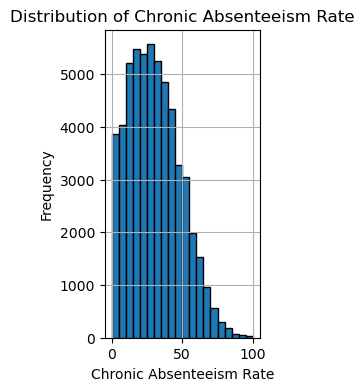

In [30]:
# distribution of chronic school absenteeism 

plt.figure(figsize=(2, 4))
plt.hist(df_attendance['%_chronically_absent'], bins=20, edgecolor='black')
plt.xlabel('Chronic Absenteeism Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Chronic Absenteeism Rate')
plt.grid(True)
plt.show()

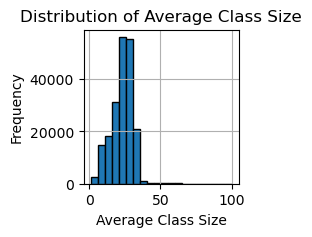

In [31]:
# distribution of average class size

plt.figure(figsize=(2, 2))
plt.hist(df_classsize['average_class_size'], bins=20, edgecolor='black')
plt.xlabel('Average Class Size')
plt.ylabel('Frequency')
plt.title('Distribution of Average Class Size')
plt.grid(True)
plt.show()

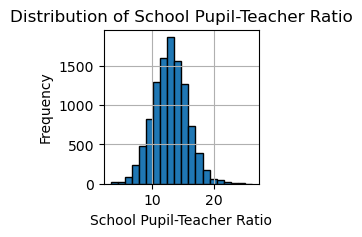

In [32]:
# distribution of pupil-teacher ratio

plt.figure(figsize=(2, 2))
plt.hist(df_PTR['school_pupil-teacher_ratio'], bins=20, edgecolor='black')
plt.xlabel('School Pupil-Teacher Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of School Pupil-Teacher Ratio')
plt.grid(True)
plt.show()

In [33]:
# calculate descriptive statistics

print("Attendance dataset")
print(df_attendance.describe())
print()
print("Class size dataset")
print(df_classsize.describe())
print()
print("Pupil-teacher ratio dataset")
print(df_PTR.describe())

Attendance dataset
        school_year   #_total_days  #_days_absent  #_days_present  \
count  55953.000000   55953.000000   55953.000000    55953.000000   
mean    2019.002270   17598.798313    1532.700945    15777.610977   
std        1.998725   18625.568690    2007.952462    16977.760505   
min     2016.000000       1.000000       0.000000        0.000000   
25%     2017.000000    8862.000000     649.000000     7805.000000   
50%     2019.000000   13516.000000    1072.000000    12035.000000   
75%     2021.000000   19474.000000    1731.000000    17626.000000   
max     2022.000000  269124.000000   50798.000000   259881.000000   

       %_attendance  #_contributing_10+_total_days_and_1+_pres_day  \
count  55953.000000                                   55953.000000   
mean      87.849330                                     110.216092   
std       16.467012                                     116.643775   
min        0.000000                                       0.000000   
25%      

Second, the distribution suggests that we can calculate the average chronic school absenteeism, class size, and pupil-teacher ratio per school per school year.


In [34]:
# calculate the averages

# group the dataframe by school and calculate the average chronic absenteeism rate over the period 2016-2023
avg_chronic_absenteeism = df_attendance.groupby('dbn_year')['%_chronically_absent'].mean()
avg_class_size = df_classsize.groupby('dbn_year')['average_class_size'].mean()
avg_PTR = df_PTR.groupby('dbn_year')['school_pupil-teacher_ratio'].mean()

# check results
print(avg_chronic_absenteeism.head())
print(avg_class_size.head())
print(avg_class_size.head())

dbn_year
01M015-2016    18.885631
01M015-2017    18.755662
01M015-2018    22.972140
01M015-2019    25.384357
01M015-2020    41.077320
Name: %_chronically_absent, dtype: float64
dbn_year
01M015-2016    17.333333
01M015-2017    15.727273
01M015-2018    14.090909
01M015-2019    15.100000
01M015-2020     9.444444
Name: average_class_size, dtype: float64
dbn_year
01M015-2016    17.333333
01M015-2017    15.727273
01M015-2018    14.090909
01M015-2019    15.100000
01M015-2020     9.444444
Name: average_class_size, dtype: float64


In [35]:
# merge the three DataFrames on the unique identifier 'dbn_year'
df_merged = pd.merge(avg_chronic_absenteeism, avg_class_size, on='dbn_year')
df_merged = pd.merge(df_merged, avg_PTR, on='dbn_year')

# reset the index after merging
df_merged = df_merged.reset_index()

# check  result
df_merged.head()



,dbn_year,%_chronically_absent,average_class_size,school_pupil-teacher_ratio
0,01M015-2016,18.885631,17.333333,8.315576
1,01M015-2017,18.755662,15.727273,7.919078
2,01M015-2018,22.972140,14.090909,7.410202
3,01M015-2019,25.384357,15.100000,8.147147
4,01M015-2020,41.077320,9.444444,8.100000


In [36]:
# rename columns
df_merged = df_merged.rename(columns={
    '%_chronically_absent': 'chronically_absent',
    'average_class_size': 'class_size',
    'school_pupil-teacher_ratio': 'PTR'
})

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10313 entries, 0 to 10312
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   dbn_year            10313 non-null  object 
 1   chronically_absent  10313 non-null  float64
 2   class_size          10313 non-null  float64
 3   PTR                 10313 non-null  float64
dtypes: float64(3), object(1)
memory usage: 322.4+ KB


In [37]:
# save as a csv file

df_merged.to_csv('df_merged.csv', index=False)

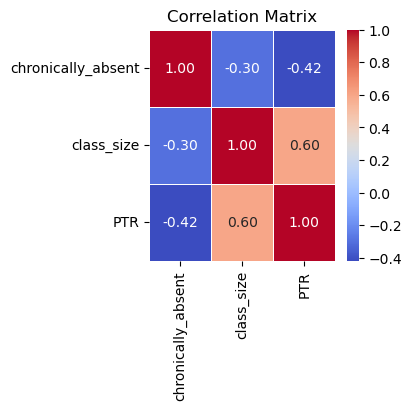

In [38]:
# calculate the correlation matrix
correlation_matrix = df_merged.corr()

# visualize the correlation matrix
plt.figure(figsize=(3, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [39]:
# check multicollinearity using variance inflation factors (VIFs)

y, X = dmatrices('chronically_absent ~ class_size + PTR', data=df_merged, return_type='dataframe')

vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

     Features        VIF
0   Intercept  33.625294
1  class_size   1.560587
2         PTR   1.560587


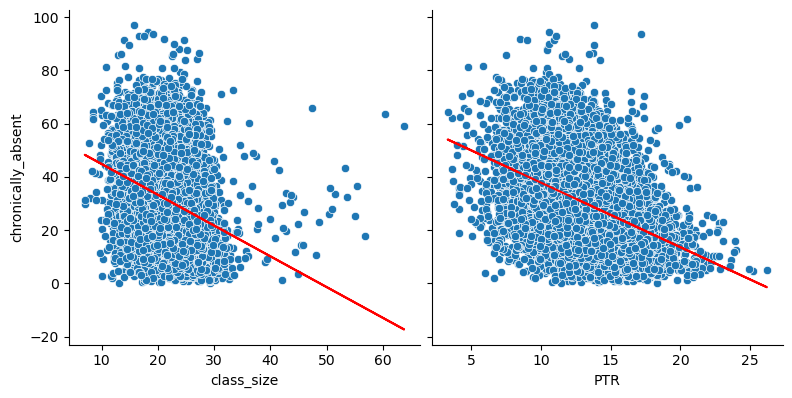

In [40]:
# visualize the relationship

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# create pairplot
pairplot = sns.pairplot(df_merged, y_vars=['chronically_absent'], x_vars=['class_size', 'PTR'], height=4)

# add regression lines
for ax in pairplot.axes.flatten():
    # Get the x and y data from the scatter plot
    x_data = ax.collections[0].get_offsets()[:, 0]
    y_data = ax.collections[0].get_offsets()[:, 1]

    # fit the regression line
    X = sm.add_constant(x_data)
    model = sm.OLS(y_data, X).fit()

    # plot the fitted line
    ax.plot(x_data, model.predict(X), color='red')

plt.show()


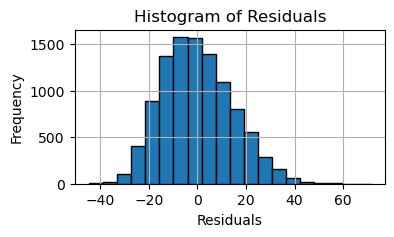

In [51]:
# create a histogram of residuals to see if a linear regression is appropriate

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming df_merged is your DataFrame with the relevant columns
# X should contain your independent variables, and y your dependent variable
X = df_merged[['class_size', 'PTR']]
y = df_merged['chronically_absent']

# Add constant to X for the intercept
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Get the predicted values and residuals
predicted_values = model.predict(X)
residuals = model.resid

# Plot residuals against predicted values
plt.figure(figsize=(4, 2))
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [42]:
# as a linear model is appropriate, we build a model chronic absenteeism - class size and pupil-teacher ratio

# we want to build a model to understand how the chronic school absenteeism rate using class size and pupil-teacher
# ratio are related, and if one of the two independent variables is better at explaining the response

df_merged['intercept'] = 1
lm = sm.OLS(df_merged['chronically_absent'], df_merged[['intercept', 'class_size', 'PTR']])
results = lm.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     chronically_absent   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     1117.
Date:                Sat, 18 Jan 2025   Prob (F-statistic):               0.00
Time:                        21:10:22   Log-Likelihood:                -42202.
No. Observations:               10313   AIC:                         8.441e+04
Df Residuals:                   10310   BIC:                         8.443e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     65.1147      0.827     78.708      0.000      63.493      66.736
class_size    -0.2917      0.043     -6.765      0.000      -0.376      -0.207
PTR           -2.1599      0.065    -33.396      0.000      -2.287      -2.033
==============================================================================
Omnibus:                      260.773   Durbin-Watson:                   0.726
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              280.595
Skew:                           0.404   Prob(JB):                     1.17e-61
Kurtosis:                       3.027   Cond. No.                         152.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Conclusion

We find a negative relationship between chronic school absenteeism and the two independent variables. In other words, against expectation, chronic school absenteeism tends to increase as class sizes and pupil-teacher ratio decrease.

First, the effect of class size is small - only 0.29.

Second, a higher pupil-teacher ratio (more pupils per teacher) is more strongly associated with a significant decrease in chronic absenteeism. The model predicts nearly 2 fewer chronically absent students for each 1-unit increase in PTR.

Other factors, such as teacher quality, classroom resources, student engagement, and school environment, play a crucial role in determining the actual educational experience. Sometimes, schools with higher pupil-teacher ratio may still be able to offer high-quality education if other factors are strong.

Indeed, the R-squared value indicates that only 17.8% of the variation in chronic absenteeism can be explained by the independent variables in the model. While this is statistically significant, it suggests that there are likely other important factors influencing chronic absenteeism that are not captured in the model. These may be teacher quality, student engagement, classroom resources and factors external to the school (health and family situation).

The p-value is 0.000 (below 0.05), indicating that the results are statistically significant. Nevertheless, they alone are inconclusive regarding the effect that reducing class sizes would have on chronic school absenteeism.

Although the study indicates that reducing class sizes may not be the most effective policy to reduce absenteeism, the findings underscore the complexity of addressing chronic absenteeism. Further research is needed to explore the role of additional variables and to evaluate the broader impact of educational policies like class size reduction.

Please refer to this visual [exploratory analysis of chronic school absenteeism in public schools in NYC](https://public.tableau.com/app/profile/lyuba3471/viz/ChronicSchoolAbsenteeisminNYCPublicSchools/ChronicSchoolAbsenteeisminNYCPublicSchools) for further information.